### Импорт

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

### Загрузка


In [8]:
dataset = pd.read_csv("./prepared_datasets/classification_si.csv")

X = dataset.drop(columns=["SI_binary"])
y = dataset["SI_binary"]

### Трейн/тест выборки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((800, 124), (201, 124))

### Набор моделей и вариации гиперпараметров для них

In [10]:
# словарь моделей и их гиперпараметров
param_grids = {
    "LogisticRegression": {
        "model": [LogisticRegression(max_iter=1000, solver="liblinear")],
        "model__C": uniform(0.01, 10),
        "model__penalty": ["l1", "l2"]
    },
    "DecisionTree": {
        "model": [DecisionTreeClassifier(random_state=42)],
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 30),
        "model__min_samples_leaf": randint(1, 15)
    },
    "RandomForest": {
        "model": [RandomForestClassifier(random_state=42, n_jobs=-1)],
        "model__n_estimators": randint(200, 800),
        "model__max_depth": randint(5, 30),
        "model__max_features": ["sqrt", "log2", None],
        "model__min_samples_split": randint(2, 20)
    },
    "CatBoost": {
        "model": [CatBoostClassifier(verbose=0, random_state=42)],
        "model__depth": randint(4, 10),
        "model__learning_rate": uniform(0.01, 0.2),
        "model__iterations": randint(200, 800),
        "model__l2_leaf_reg": uniform(1.0, 9.0)
    },
    "MLP": {
        "model": [MLPClassifier(max_iter=600, random_state=42, early_stopping=True)],
        "model__hidden_layer_sizes": [(64,32), (128,64), (256,128)],
        "model__alpha": uniform(1e-4, 1e-2),
        "model__learning_rate_init": uniform(1e-3, 5e-2)
    },
    "SVC": {
        "model": [SVC(probability=True, max_iter=2000)],
        "model__kernel": ["rbf", "linear"],
        "model__C": uniform(0.1, 10.0),
        "model__gamma": ["scale", "auto"]
    }
}


### Поиск лучших гиперпараметров и сводная таблица

In [11]:

results = []

for name, param_grid in param_grids.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()), # для нейросетей и SVC это обязательно
        ("model", param_grid["model"][0])
    ])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid,
        n_iter=12,
        cv=3,
        scoring="f1", # подбираем по F1
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else y_pred

    results.append({
        "Model": name,
        "Best Params": search.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results).sort_values("F1", ascending=False)
results_df


,Model,Best Params,Accuracy,Precision,Recall,F1,ROC-AUC
5,SVC,"{'model': SVC(max_iter=2000, probability=True)...",0.626866,0.621359,0.64,0.630542,0.677871
2,RandomForest,"{'model': RandomForestClassifier(n_jobs=-1, ra...",0.631841,0.641304,0.59,0.614583,0.682624
3,CatBoost,{'model': <catboost.core.CatBoostClassifier ob...,0.611940,0.617021,0.58,0.597938,0.657772
0,LogisticRegression,"{'model': LogisticRegression(max_iter=1000, so...",0.592040,0.588235,0.60,0.594059,0.632921
1,DecisionTree,{'model': DecisionTreeClassifier(random_state=...,0.587065,0.585859,0.58,0.582915,0.609802
4,MLP,"{'model': MLPClassifier(early_stopping=True, m...",0.616915,0.709091,0.39,0.503226,0.677178


### Графики сравнения моделей по метрикам

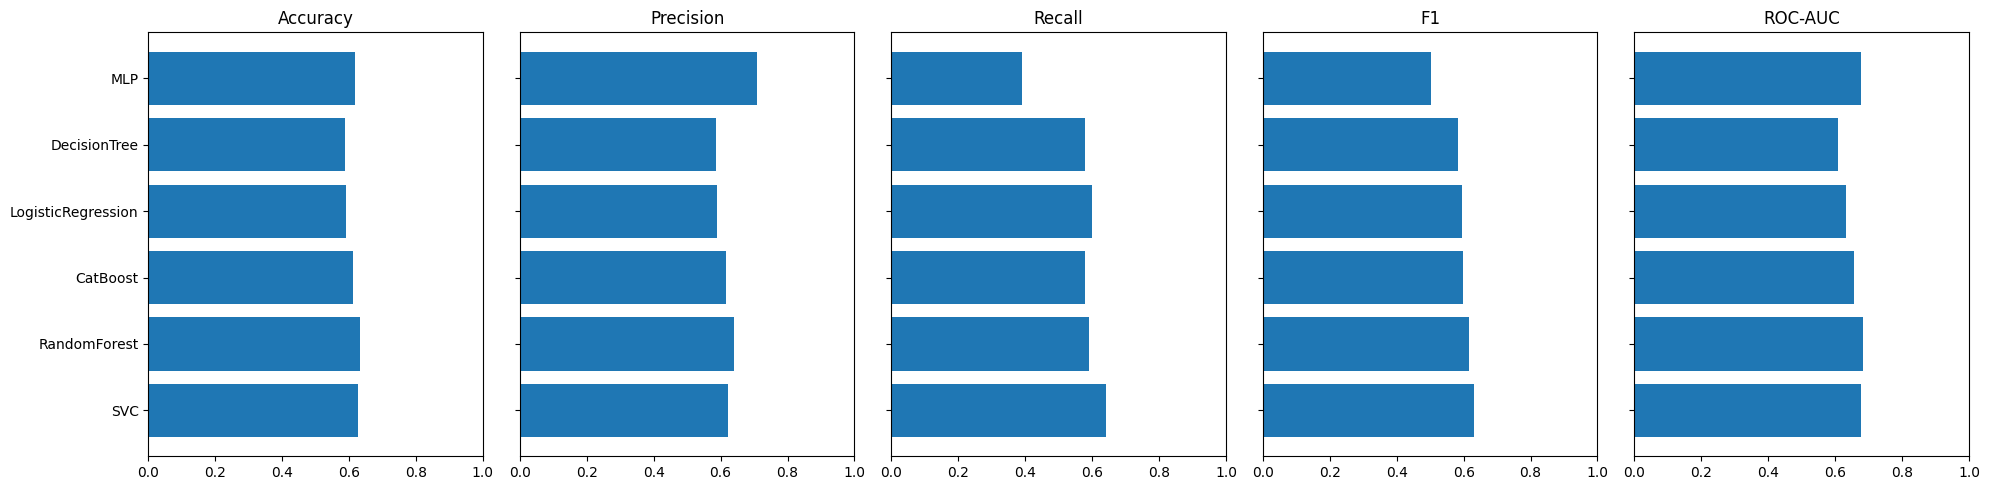

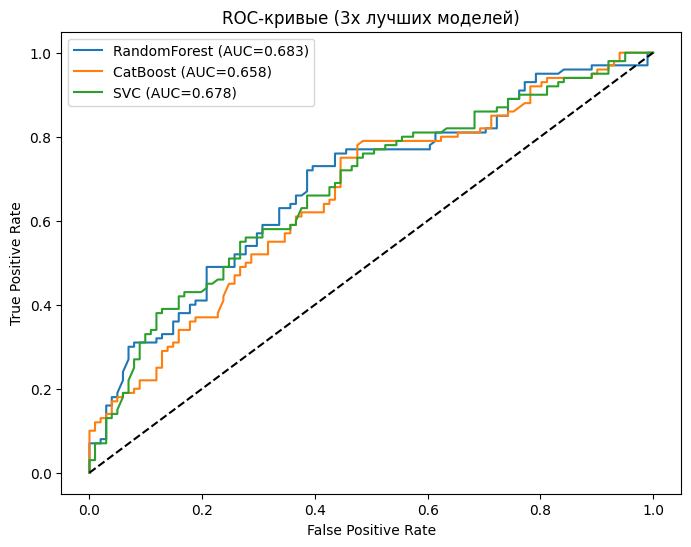

In [12]:
# Barplot всех моделей
metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=True)
for i, metric in enumerate(metrics):
    axes[i].barh(results_df["Model"], results_df[metric])
    axes[i].set_title(metric)
    axes[i].set_xlim(0, 1)
plt.tight_layout()
plt.show()

# ROC-кривые 3х лучших моделей
top_models = results_df.head(3)["Model"].values  # берём лучшие по F1
plt.figure(figsize=(8,6))

for name, param_grid in param_grids.items():
    if name in top_models:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", param_grid["model"][0])
        ])
        # обучаем на лучших параметрах
        best_params = results_df.loc[results_df["Model"] == name, "Best Params"].values[0]
        pipe.set_params(**best_params)
        pipe.fit(X_train, y_train)
        y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else pipe.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые (3х лучших моделей)")
plt.legend()
plt.show()


### Вывод по данной задаче

Наиболее удачной моделью для задачи классификации SI > медианы стала SVC, показавшая лучший результат по метрике F1 (0.63), а также достаточно высокий ROC-AUC (0.68). 
Модель хорошо сбалансировала precision и recall, что важно для данной задачи.

Сравнимо высокий результат показал RandomForest (F1 = 0.61, ROC-AUC = 0.68).
Это подтверждает наличие нелинейных зависимостей в данных.

CatBoost также продемонстрировал приемлемое качество (F1 = 0.60), но уступил SVC и RandomForest.
Простые модели (LogisticRegression и DecisionTree) ожидаемо показали более слабые результаты.

Интересно, что MLP показал высокий precision (0.71), но при этом низкий recall (0.39), из-за чего итоговый F1 оказался хуже — модель склонна «бояться» давать положительные предсказания.

<br>

Для улучшения качества можно:

  - расширить поиск гиперпараметров для SVC и RandomForest;

  - рассмотреть ансамблирование SVC и CatBoost, чтобы объединить сильные стороны;

  - попробовать методы балансировки классов (SMOTE, class_weight), чтобы улучшить recall у MLP и CatBoost.